In [11]:
import torch
import random
import numpy as np

from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from ml_glasses.commons import ToTensor
from ml_glasses.data import MeGlassDataset
from ml_glasses.model import GlassesClassifier

In [12]:
DEVICE = 'cpu'
SEED = 5

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [13]:
with open('meta.txt', 'r') as file:
    lines = file.readlines()

random.shuffle(lines)
lines_train, lines_val = train_test_split(lines, test_size=0.15)

dataset_train = MeGlassDataset(lines_train, 'MeGlass_120x120/', transform=ToTensor())
dataset_val = MeGlassDataset(lines_val, 'MeGlass_120x120/', transform=ToTensor())

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=True)

In [14]:
model = GlassesClassifier()
model.to(DEVICE)

GlassesClassifier(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): Adapt

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
best_val_accuracy = 0.0

for epoch in range(10):
    model.train(True)
    print("-- EPOCH", epoch)
    running_loss = 0.0
    
    for i, batch in tqdm(enumerate(dataloader_train)):
        X = batch['image'].to(DEVICE)
        y = batch['label'].to(DEVICE)
        
        output = model(X)
        loss = criterion(output, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.train(False)
    correct = 0
    total = 0
    for batch in dataloader_val:
        X_val = batch['image'].to(DEVICE)
        y_val = batch['label'].to(DEVICE)
        
        pred = model(X_val)
        _, pred = torch.max(pred.data, 1)
        total += y_val.size(0)
        correct += (pred == y_val).sum().item()
        
    val_accuracy = correct / total
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "./checkpoint.pt")
        
    print('Validation accuracy: %d %%', (100 * val_accuracy))


0it [00:00, ?it/s]
1it [00:00,  1.53it/s]
2it [00:01,  1.48it/s]
3it [00:02,  1.47it/s]
4it [00:02,  1.49it/s]
5it [00:03,  1.52it/s]
6it [00:03,  1.54it/s]
7it [00:04,  1.56it/s]
8it [00:05,  1.56it/s]
9it [00:05,  1.55it/s]
10it [00:06,  1.54it/s]
11it [00:07,  1.55it/s]
12it [00:07,  1.56it/s]
13it [00:08,  1.55it/s]
14it [00:09,  1.50it/s]
15it [00:09,  1.50it/s]
16it [00:10,  1.49it/s]
17it [00:11,  1.50it/s]
18it [00:11,  1.51it/s]
19it [00:12,  1.52it/s]
20it [00:13,  1.53it/s]
21it [00:13,  1.56it/s]
22it [00:14,  1.59it/s]
23it [00:14,  1.61it/s]
24it [00:15,  1.65it/s]
25it [00:16,  1.68it/s]
26it [00:16,  1.70it/s]
27it [00:17,  1.71it/s]

-- EPOCH 0


In [15]:
model.train(False)
correct = 0
total = 0

false_positive = 0
false_negative = 0

positive = 0

for X_val, y_val in tqdm(dataloader_val):
    X_val = X_val.to(DEVICE)
    y_val = y_val.to(DEVICE)
    
    pred = model(X_val)
    _, pred = torch.max(pred.data, 1)
    total += y_val.size(0)
    correct += (pred == y_val).sum().item()
    false_positive += ((pred == 1) & (y_val == 0)).sum().item()
    false_negative += ((pred == 0) & (y_val == 1)).sum().item()
    positive += y_val.sum().item()

100%|██████████| 225/225 [00:05<00:00, 43.20it/s]


In [11]:
false_positive

15

In [12]:
for X_val, y_val in tqdm(dataloader_val):
    X = X_val.to(DEVICE)
    y = y_val.to(DEVICE)
    break
    

100%|██████████| 225/225 [00:04<00:00, 47.14it/s]


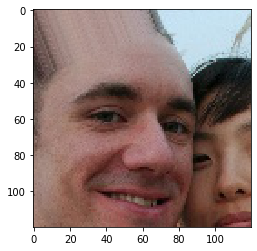

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(X_val[1].detach().cpu().numpy().transpose((1, 2, 0)))
plt.show()

In [18]:
X_val[0].transpose(0, 2).shape

torch.Size([120, 120, 3])